# 統計的なARIMAモデルを用いて、人流データを予測する 

必要なライブラリーをインポートする。

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## P003 

CSVファイルを読み込む

In [60]:
path = Path('../data/num_file/p003.csv')
p003 = pd.read_csv(path)

print(p003)

「date」と「hour」のコラムを一つにまとめる

In [61]:
p003['datetime'] = pd.to_datetime(p003['date'])+pd.to_timedelta(p003['hour'], unit='h')
p003 = p003.drop(['date', 'hour'], axis=1)
p003.set_index('datetime', inplace=True)
p003.columns=['y']
print(p003)

データの形を具体的な図を表す。

**前**

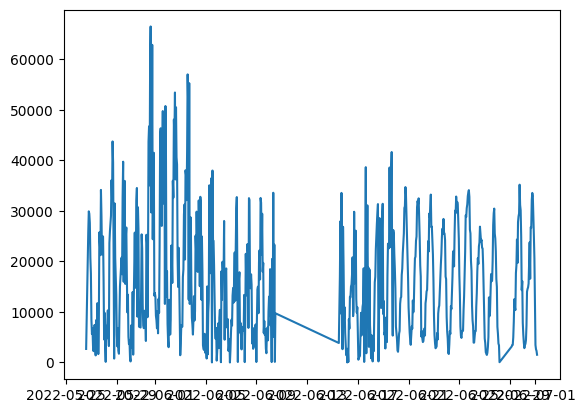

In [62]:
plt.plot(p003['y'])

**後**

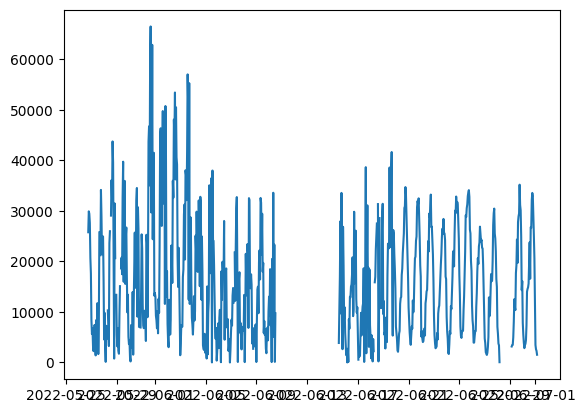

In [63]:
p003 = p003.resample('H').mean()
p003.index.freq = 'H'
plt.plot(p003['y'])

## データの準備

データの損失を検出する

In [64]:
p003_cp = p003.copy()
print(p003.info)

In [65]:
from common.util import handle_missing_data
handle_missing_data(p003_cp)

/Users/phongwitsrikokcharoen/Documents/GitHub/people_flow/analysis/common/util.py:72: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.isna().sum())


一つのステップの予測を用いて、データを補正する

In [66]:
from common.util import one_step_forecast
p003_os = one_step_forecast(p003_cp, 5)
print(p003_os)

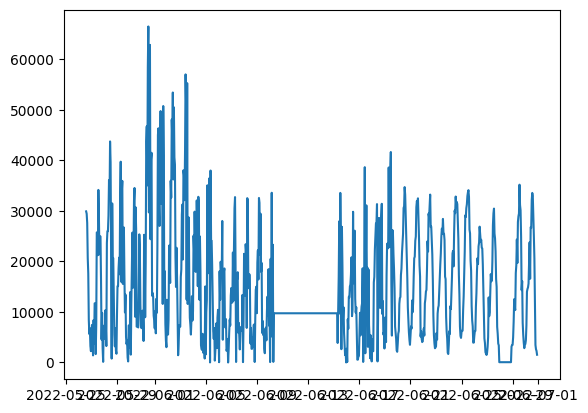

In [67]:
plt.plot(p003_os['y'])

2つの学習セットとテストセットに分ける。

In [68]:
from common.util import split_data

train, test = split_data(p003_os)
print(f'Train: {len(train)} Test: {len(test)}')
print(test)

データを正規化する

In [69]:
from common.util import Standardize

scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_original = scaler.inverse(train_s)
y_train_original = scaler.inverse_y(train_s['y'])
print(train_original)
print(y_train_original)

## ARIMAでの予測

In [70]:
from pmdarima import auto_arima
from sktime.forecasting.all import ForecastingHorizon

In [71]:
n = len(test)
fh = ForecastingHorizon(np.arange(n)+1)
arima = auto_arima(y=train['y'], seasonal=True, m=12, suppress_warnings=True)

In [72]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  722
Model:             SARIMAX(1, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -7467.278
Date:                              Sat, 16 Sep 2023   AIC                          14948.556
Time:                                      15:03:43   BIC                          14980.621
Sample:                                  05-26-2022   HQIC                         14960.934
                                       - 06-25-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7811      0.063     12.396      0.000       0.658       0.905
ma.L1         -1.5372      0.066    -23.203      0.000      -1.667      -1.407
ma.L2          0.6592      0.061     10.819      0.000       0.540       0.779
ma.L3         -0.1061      0.035     -3.001      0.003      -0.175      -0.037
ar.S.L12      -0.9356      0.026    -36.202      0.000      -0.986      -0.885
ma.S.L12       0.7721      0.048     16.194      0.000       0.679       0.866
sigma2      6.719e+07   2.75e-10   2.44e+17      0.000    6.72e+07    6.72e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               235.81
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.6e+33. Standard errors may be unstable.
"""

In [73]:
test['ARIMA'] = arima.predict(n)
print(test)

/var/folders/7l/hpz3ccrd3_zdd3c0rbn38bnh0000gn/T/ipykernel_15501/745698647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA'] = arima.predict(n)


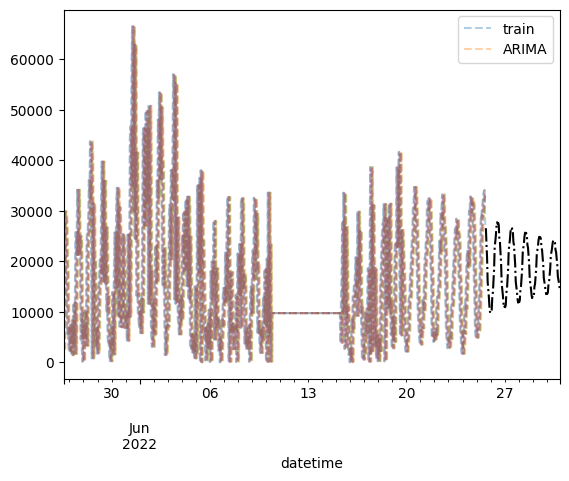

In [75]:
ax = train.plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
plt.legend(['train', 'ARIMA'])
plt.show()